Total records:  1194464


Text(0.5, 1.0, 'Record Count')

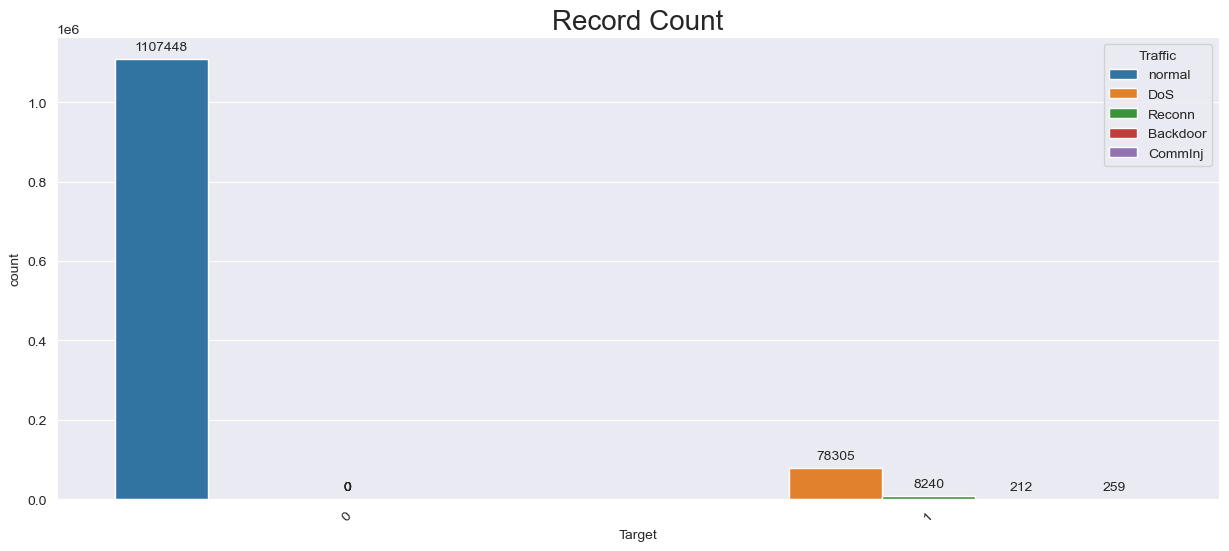

In [1]:
################################################################################
# Class distribution
################################################################################

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

df = pd.read_csv(os.getcwd() + '/../../data/wustl-iiot/population.csv', low_memory=False)
print("Total records: ", len(df))

plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
s = sns.countplot(data=df, x='Target', hue='Traffic')
for p in s.patches:
    s.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'center',
               xytext = (0, 9),
               textcoords = 'offset points')
plt.title('Record Count', fontsize=20)

In [7]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate
from sklearn.model_selection import train_test_split

dataset_name = "wustl-iiot"
dataset_type = "population"

# Load dateset
df = pd.read_csv(os.getcwd() + f'/../../data/{dataset_name}/{dataset_type}.csv')

# Change column name 'attack' to 'label' for consistency
df.rename(columns={'Target': 'label'}, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['label', 'Traffic']),
    df['label'],
    test_size=0.2,
    random_state=42
)

# Print sizes in a table
table = [
    ["Training (Attack)", f"{len(X_train[y_train == 1])} ({len(X_train[y_train == 1]) / len(df) * 100:.2f}%)"],
    ["Training (Benign)", f"{len(X_train[y_train == 0])} ({len(X_train[y_train == 0]) / len(df) * 100:.2f}%)"],
    ["Training (Total)", f"{len(X_train)} ({len(X_train) / len(df) * 100:.2f}%)"],
    ["Test (Attack)", f"{len(X_test[y_test == 1])} ({len(X_test[y_test == 1]) / len(df) * 100:.2f}%)"],
    ["Test (Benign)", f"{len(X_test[y_test == 0])} ({len(X_test[y_test == 0]) / len(df) * 100:.2f}%)"],
    ["Test (Total)", f"{len(X_test)} ({len(X_test) / len(df) * 100:.2f}%)"],
    ["Total (Attack)", f"{len(df[df['label'] == 1])} ({len(df[df['label'] == 1]) / len(df) * 100:.2f}%)"],
    ["Total (Benign)", f"{len(df[df['label'] == 0])} ({len(df[df['label'] == 0]) / len(df) * 100:.2f}%)"],
    ["Total", len(df)]
]
print(tabulate(table, headers=['Set', 'Size']))

Set                Size
-----------------  ----------------
Training (Attack)  69680 (5.83%)
Training (Benign)  885891 (74.17%)
Training (Total)   955571 (80.00%)
Test (Attack)      17336 (1.45%)
Test (Benign)      221557 (18.55%)
Test (Total)       238893 (20.00%)
Total (Attack)     87016 (7.28%)
Total (Benign)     1107448 (92.72%)
Total              1194464


In [8]:
################################################################################
# Create sample dataset for fine-tuning
################################################################################

import pandas as pd
import os

def formatted(system_msg, user_msg, assistant_msg, model=None):
    if model == "TinyLlama/TinyLlama-1.1B-Chat-v1.0":
        msg = ""
        if system_msg:
            msg += f"<|system|>\n{system_msg}</s>\n"
        if user_msg:
            msg += f"<|user|>\n{user_msg}</s>\n"
        if assistant_msg:
            msg += f"<|assistant|>\n{assistant_msg}</s>"
        else:
            msg += "<|assistant|>\n"
        return msg

    elif model == "meta-llama/Llama-3.2-1B-Instruct":
        msg = ""
        if system_msg:
            msg += f"<|start_header_id|>system<|end_header_id|>\n{system_msg}<|eot_id|>\n"
        if user_msg:
            msg += f"<|start_header_id|>user<|end_header_id|>\n{user_msg}<|eot_id|>\n"
        if assistant_msg:
            msg += f"<|start_header_id|>assistant<|end_header_id|>\n{assistant_msg}<|eot_id|>"
        else:
            msg += "<|start_header_id|>assistant<|end_header_id|>\n"
        return msg

    elif model == "google/gemma-3-1b-it":
        msg = ""
        if system_msg and user_msg:
            msg += f"<start_of_turn>user\n{system_msg}\n\n{user_msg}<end_of_turn>\n"
        elif user_msg:
            msg += f"<start_of_turn>user\n{user_msg}<end_of_turn>\n"
        if assistant_msg:
            msg += f"<start_of_turn>model\n{assistant_msg}<end_of_turn>\n"
        else:
            msg += "<start_of_turn>model\n"
        return msg

    else:
        raise ValueError(f"Unsupported model: {model}")

def prepare_train_data(X, y, model):
    system_msg = "You are a skilled network data analyst."
    user_msgs = [f"Identify whether following network data entry is attack (1) or benign (0). Output only 1 or 0.\n```{x}```" for x in X.to_dict(orient='records')]
    assistant_msgs = [str(label) for label in y.tolist()]
    dataset_df = pd.DataFrame({
        "text": [formatted("", user_msg, assistant_msg, model) for user_msg, assistant_msg in zip(user_msgs, assistant_msgs)]
    })
    return dataset_df

def prepare_test_data(X, y, model):
    system_msg = "You are a skilled network data analyst."
    user_msgs = [f"Identify whether following network data entry is attack (1) or benign (0). Output only 1 or 0.\n```{x}```" for x in X.to_dict(orient='records')]
    dataset_df = pd.DataFrame({
        "text": [formatted("", user_msg, "", model) for user_msg in user_msgs],
        "label": [str(i) for i in y.tolist()]
    })
    return dataset_df

In [11]:
# model_name = "google/gemma-3-1b-it"
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

dataset_train_df = prepare_train_data(X_train, y_train, model_name)
dataset_test_df = prepare_test_data(X_test, y_test, model_name)

# Save dataset to CSV
dataset_train_df.to_csv(os.getcwd() + f'/../../data/{dataset_name}/{model_name.split("/")[1].lower()}-formatted-{dataset_type}-train.csv', index=False)
dataset_test_df.to_csv(os.getcwd() + f'/../../data/{dataset_name}/{model_name.split("/")[1].lower()}-formatted-{dataset_type}-test.csv', index=False)